## <center> EE5708: Data Analytics Laboratory </center>
#### <center> Assignment 1: Linear Regression </center>
#### <center> Submitted by: Aman Kumar, EE21B013 </center>

### Importing the necessary packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import LabelBinarizer 

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
plt.rcParams.update({'font.size': 13})

### Loading in the data

Since we already have a unique ID for each passenger, we shall use this ID for indexing; adding a separate index column is not necessary. Hence, we set the 'PassengerId' column as the index column.

In [115]:
df_train = pd.read_excel("train.xlsx", index_col='PassengerId')
df_test = pd.read_excel("test.xlsx", index_col='PassengerId')

We take a quick look at the loaded training set. We shall keep the test set untouched and use it only at the very end for evaluation purposes.

In [116]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Exploratory Data Analysis

Basic information regarding the dataset:

In [117]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [118]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [119]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [120]:
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

There are missing values in the columns "Age", "Cabin" and "Embarked". We will look at each column separately.

#### Handling missing values:

#### Age

Let us see how age is distributed:

In [121]:
# percent of missing "Age" 
print('Percent of missing "Age" records is %.2f%%' %((df_train['Age'].isnull().sum()/df_train.shape[0])*100))

Percent of missing "Age" records is 19.87%


~20% of entries for passenger age are missing. Let's see what the 'Age' variable looks like in general

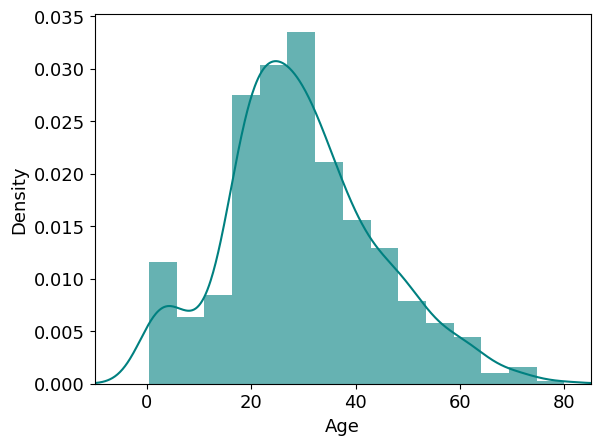

In [122]:
ax = df_train["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
df_train["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.savefig("Figures/age_distribution.png")
plt.show()

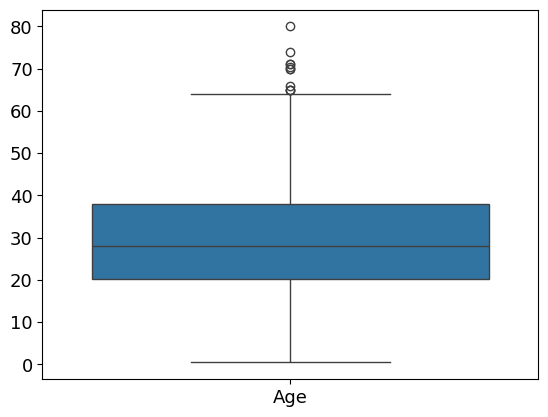

In [123]:
sns.boxplot(data = df_train[["Age"]])
plt.savefig("Figures/age_dist.png")

We see that the data is right-skewed. For a skewwed dataset, it is more appropriate to use median imputation than mean imputation.

In [124]:
age_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
age_imputer.fit(np.array(df_train['Age']).reshape(-1, 1))

SimpleImputer(strategy='median')

In [125]:
imputed_age = age_imputer.transform(np.array(df_train['Age']).reshape(-1, 1))

In [126]:
df_train['Age'] = imputed_age

In [127]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


#### Fare (only for test set)

In [128]:
fare_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
fare_imputer.fit(np.array(df_train['Fare']).reshape(-1, 1))

SimpleImputer()

#### Embarked - Missing values

In [129]:
# percent of missing "Embarked" 
print('Percent of missing "Embarked" records is %.2f%%' %((df_train['Embarked'].isnull().sum()/df_train.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


We only have two missing values. So we simply drop these columns:

In [130]:
df_train = df_train.dropna(subset = ['Embarked'])

In [131]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       889 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Cabin     202 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.3+ KB


#### Cabin - Missing values

We first take a look at the values:

In [132]:
# percent of missing "Cabin" 
print('Percent of missing "Cabin" records is %.2f%%' %((df_train['Cabin'].isnull().sum()/df_train.shape[0])*100))

Percent of missing "Cabin" records is 77.28%


In [133]:
df_train['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'C83', 'F33', 'F G73',
       'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69',
       'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32',
       'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87',
       'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49',
       'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66',
       'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128',
       'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64',
       'E24',


- **Cabin Feature**:   
  With 77% of the records missing, imputing the `Cabin` variable and using it for prediction is not advisable.
  Since each person may have a unique cabin, imputing missing values isn't practical. Moreover, the `Cabin` feature is missing for the majority of points in both the training and test sets. As a result, we will not use this feature in predictive modeling. However, we may explore it later for any insightful interpretations.


In [134]:
# check missing values in adjusted train data
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
dtype: int64

#### Correlation of individual features with survival

First, we see how balanced the dataset is with respect to the number of individuals who survived/ did not survive:

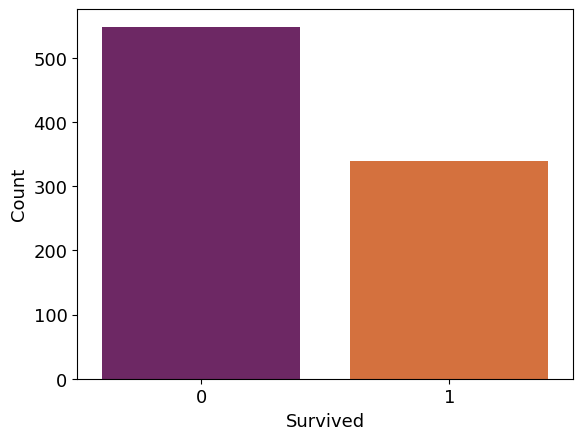

In [135]:
sns.countplot(x='Survived', hue='Survived', data=df_train, palette='inferno', legend=False)
plt.ylabel("Count")
plt.savefig('Figures/data_balance.png')


In [136]:
# preview adjusted train data
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [137]:
print("Percentage of people who did not survive = ", (1-df_train['Survived'].sum()/len(df_train['Survived']))*100)
print("Percentage of people who survived = ", (df_train['Survived'].sum()/len(df_train['Survived']))*100)

Percentage of people who did not survive =  61.75478065241844
Percentage of people who survived =  38.24521934758155


There is a slight data imbalance; i.e. we have more data of people who did not survive when compared to people who survived.

Although this could be due to a bias in data collection, this could also be because there is inherently more people who did not survive as compared to people who survived.

Next, we check how each individual feature relates with survival:

#### Understanding the "Survived" Variable

The "Survived" variable is binary, where 0 represents "did not survive" and 1 represents "survived". The mean of a subset of this column indicates the fraction of people who survived within that subset, also known as the survival rate.

This allows us to use bar plots to visualize and quantify the survival rate across different subsets of the data.


#### Passenger class:

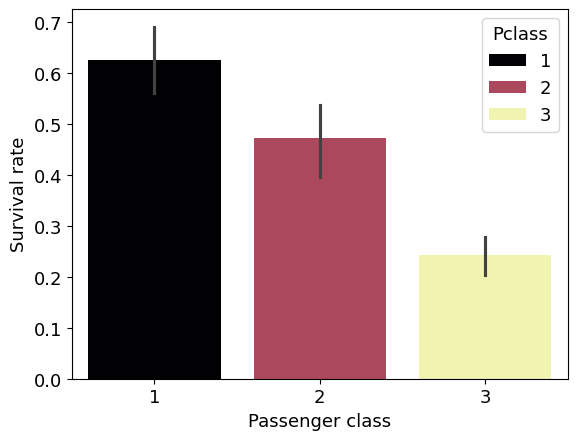

In [138]:
sns.barplot(x='Pclass', y='Survived', hue='Pclass', data=df_train, palette='inferno', dodge=False)
plt.xlabel("Passenger class")
plt.ylabel("Survival rate")
plt.savefig('Figures/class_plot.png')


It seems like a higher fraction of passengers belonging to a higher passenger class survived. This could be <b> due to the fact that higher class tickets were often taken by people who were economically and socially privilaged thereby giving them an advantage over the lesser privilaged sections in times of such crises. </b>


#### Sex:

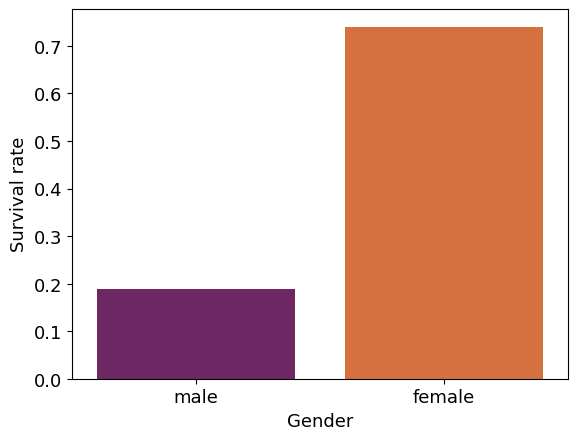

In [139]:
sns.barplot(x='Sex', y='Survived', hue='Sex', data=df_train, palette='inferno', errorbar=None, dodge=False)
plt.xlabel("Gender")
plt.ylabel("Survival rate")
plt.savefig('Figures/sex_plot.png')


The survival rate is higher for females as compared to males. This could be because of the social norm to give preference to women and children during times of disasters.

#### Exploration of Age

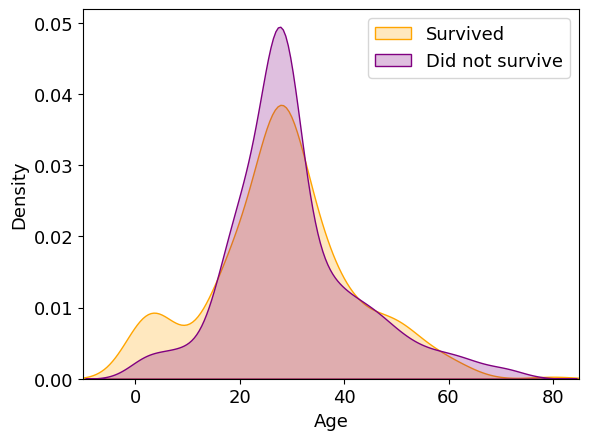

In [140]:
ax = sns.kdeplot(df_train["Age"][df_train.Survived == 1], fill=True, color="orange")
sns.kdeplot(df_train["Age"][df_train.Survived == 0], fill=True, color="purple")
plt.legend(['Survived', 'Did not survive'])
ax.set(xlabel='Age')
ax.set(ylabel='Density')
plt.xlim(-10, 85)
plt.savefig('Figures/Agevssurvival.png')


We make two observations:

- There was a greater chance for children to survive. Again, this could be because priority was given to women and children during evacuation.
- A greater fraction of people in the age group 20-30 did not survive; this could be because they stayed back to aid younger and older individuals during evacuation.

#### Exploration of Fare

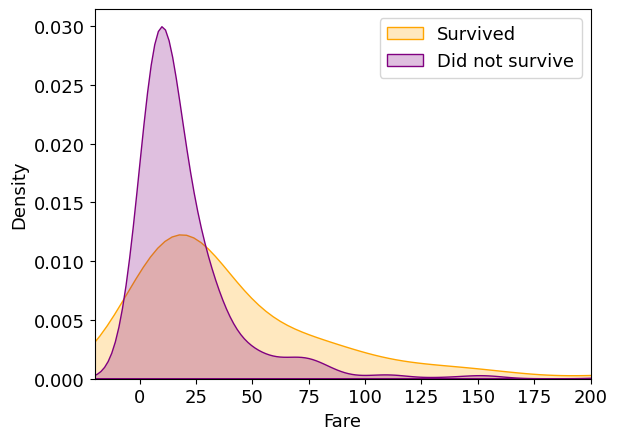

In [141]:
ax = sns.kdeplot(df_train["Fare"][df_train.Survived == 1], fill=True, color="orange")
sns.kdeplot(df_train["Fare"][df_train.Survived == 0], fill=True, color="purple")
plt.legend(['Survived', 'Did not survive'])
ax.set(xlabel='Fare')
ax.set(ylabel='Density')
plt.xlim(-20, 200)
plt.savefig('Figures/farevssurvival.png')


It can be seen that, in general, people who pay a higher fare tend to have a higher chance for survival. This could again be associated with higher social and economic status and the associated privilage.

#### Exploration of Embarked Port

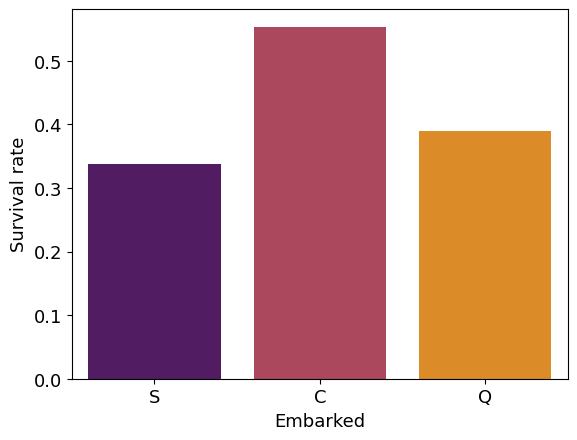

In [142]:
sns.barplot(x='Embarked', y='Survived', hue='Embarked', data=df_train, palette='inferno', errorbar=None, dodge=False)
plt.ylabel("Survival rate")
plt.legend([], [], frameon=False)  # Removes the unnecessary legend
plt.savefig('Figures/embarked_plot.png')


In [143]:
pd.pivot_table(index = 'Embarked',data = df_train,values = ['Fare','Survived'],aggfunc = {'Fare':np.mean,'Survived':np.mean})

,Fare,Survived
Embarked,,
C,59.954144,0.553571
Q,13.276030,0.389610
S,27.079812,0.336957


Higher survival rate for people who boarded from Cherbourg could be attributed to the higher fare paid.

#### Cabin:

We extract only the cabin group and see if this has any impact on the survival rate:

In [144]:
def extract_cabin_group(df):
    df['Cabin'].fillna(value = 'U',inplace = True)
    df['Cabin_group'] = df['Cabin'].apply(lambda x: x[0])
    return df 

In [145]:
df_train = extract_cabin_group(df_train)

In [146]:
df_train['Cabin_group'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

We set the cabins which we dont know to U (for unknown)

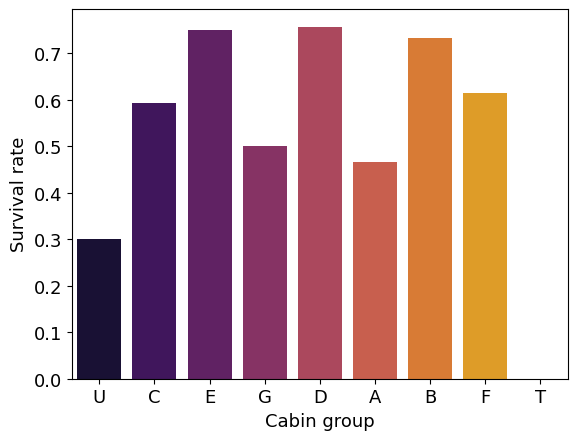

In [148]:
sns.barplot(x='Cabin_group', y='Survived', hue='Cabin_group', data=df_train, palette='inferno', errorbar=None, dodge=False)
plt.xlabel("Cabin group")
plt.ylabel("Survival rate")
plt.legend([], [], frameon=False)  # Removes the unnecessary legend
plt.savefig('Figures/cabin_group_plot.png')


Due to the limited data available, it is not possible to make conclusive statements reagrding the impact of cabin group on survival rate. However, if more data is available, it might be possible to correlate the cabin group with survival rate as we intuitively expect certain cabin groups to have more access to lifeboats and such similar factors.

### Feature Engineering

For the feature `Name`, we do not expect name of an individual to directly have any influence on his/her survival chance. However, the honorofics associated with the name might have an impact on suurvival chance. Hence, we extract the honorifics:

In [37]:
def extract_title(df):
    title = []
    for name in df['Name']:
        split_name = name.split(',')
        title_el = split_name[1].split('.')[0]
        title.append(title_el.strip())
    df.loc[:, 'title'] = title 
    return df  

In [38]:
df_train = extract_title(df_train)

In [39]:
df_train['title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

The categorical features we now consider are "Pclass", "Sex", "Embarked" and "title".

Of these, "Pclass" has a numbering by default; as we have seen before, higher the class of the passenger, higher is the chance of survival. Hence, we maintain the numerical ordering for this feature.

For the other features, we implement one-hot encoding:

In [40]:
def one_hot_encoding(df, cols):
    for el in cols:
        df = pd.concat([df, pd.get_dummies(df[el], prefix=el)] , axis = 1)
    return df

In [41]:
class OneHot:
    
    def __init__(self):
        self.columns = ['Sex','Embarked', 'title']
        self.encoders = []
        
    def fit(self,df):
        for col in self.columns:
            encoder = LabelBinarizer()
            encoder.fit(df[col])
            self.encoders.append(encoder) 
        
    def transform(self,df):
        for i in range(len(self.columns)):
            encoder = self.encoders[i]
            if i==0:
                df = df.join(pd.DataFrame(encoder.transform(df[self.columns[i]]),
                                          columns = encoder.classes_[:-1],index = df.index))
            else:
                df = df.join(pd.DataFrame(encoder.transform(df[self.columns[i]])[:,:-1],
                          columns=encoder.classes_[:-1], 
                          index=df.index),rsuffix = self.columns[i])
            df.drop(self.columns[i],axis=1,inplace = True)
        return df
    

In [42]:
#df_train = one_hot_encoding(df_train, ['Sex', 'Embarked', 'title'])
obj3 = OneHot()
obj3.fit(df_train)
df_train = obj3.transform(df_train)

In [43]:
df_train.columns

Index(['Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Cabin_group', 'female', 'C', 'Q', 'Capt', 'Col', 'Don', 'Dr',
       'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr',
       'Mrs', 'Ms', 'Rev', 'Sir'],
      dtype='object')

In [44]:
df_train.drop(labels = ['Name', 'Ticket', 'Cabin', 'Cabin_group'], axis = 1, inplace = True)

In [45]:
df_train.shape

(889, 25)

In [46]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 1 to 891
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Fare      889 non-null    float64
 6   female    889 non-null    int64  
 7   C         889 non-null    int64  
 8   Q         889 non-null    int64  
 9   Capt      889 non-null    int64  
 10  Col       889 non-null    int64  
 11  Don       889 non-null    int64  
 12  Dr        889 non-null    int64  
 13  Jonkheer  889 non-null    int64  
 14  Lady      889 non-null    int64  
 15  Major     889 non-null    int64  
 16  Master    889 non-null    int64  
 17  Miss      889 non-null    int64  
 18  Mlle      889 non-null    int64  
 19  Mme       889 non-null    int64  
 20  Mr        889 non-null    int64  
 21

### Implementing Logistic Regression

Separating data matrix and labels:

In [47]:
X_train = np.array(df_train.iloc[:, 1:])
y_train = np.array(df_train.iloc[:,0])

For logistic regression, we have the regularization strength as a hyper parameter. To obtain the best value of regularization strength, which will be denoted by C from now on, we perfrom cross validation. To perfrom this, we use the LogisticRegressionCV module provided by scikit learn. 

By specifying the value of C as 10 in the parameter list, we pass a grid of 10 C values chosen in a logarithmic scale between 1e-4 and 1e4.

We also take a list of values for l1 ratio which decides which combination of l1 and l2 should be used as the penalty function:

In [48]:
l_ratio = np.linspace(0,1,10)

In [49]:
model = LogisticRegressionCV(Cs = 10, max_iter = 50000)

In [50]:
model.fit(X_train, y_train)

LogisticRegressionCV(max_iter=50000)

In [51]:
model.C_

array([21.5443469])

In [52]:
y_train_pred = model.predict(X_train)

In [53]:
accuracy_score(y_train_pred,y_train)

0.8312710911136107

### Evaluating on the test set

#### Preprocessing the test set

In [54]:
imputed_age = age_imputer.transform(np.array(df_test['Age']).reshape(-1, 1))
df_test['Age'] = imputed_age

imputed_fare = fare_imputer.transform(np.array(df_test['Fare']).reshape(-1, 1))
df_test['Fare'] = imputed_fare

df_test = extract_title(df_test)

df_test = obj3.transform(df_test)

df_test.drop(labels = ['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 892 to 1309
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Age       418 non-null    float64
 2   SibSp     418 non-null    int64  
 3   Parch     418 non-null    int64  
 4   Fare      418 non-null    float64
 5   female    418 non-null    int64  
 6   C         418 non-null    int64  
 7   Q         418 non-null    int64  
 8   Capt      418 non-null    int64  
 9   Col       418 non-null    int64  
 10  Don       418 non-null    int64  
 11  Dr        418 non-null    int64  
 12  Jonkheer  418 non-null    int64  
 13  Lady      418 non-null    int64  
 14  Major     418 non-null    int64  
 15  Master    418 non-null    int64  
 16  Miss      418 non-null    int64  
 17  Mlle      418 non-null    int64  
 18  Mme       418 non-null    int64  
 19  Mr        418 non-null    int64  
 20  Mrs       418 non-null    int64  


In [56]:
X_test = np.array(df_test)

In [57]:
y_test_pred = model.predict(X_test)

In [58]:
pid = np.arange(892, 1310)

In [59]:
pid

array([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,
        903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,
        914,  915,  916,  917,  918,  919,  920,  921,  922,  923,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  934,  935,
        936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
        947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 10

In [60]:
out = pd.DataFrame(data = {'PassengerId':pid, 'Survived':y_test_pred})

In [61]:
out

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [62]:
out.to_csv("test_predictions.csv", index = False)

### Evaluating the model

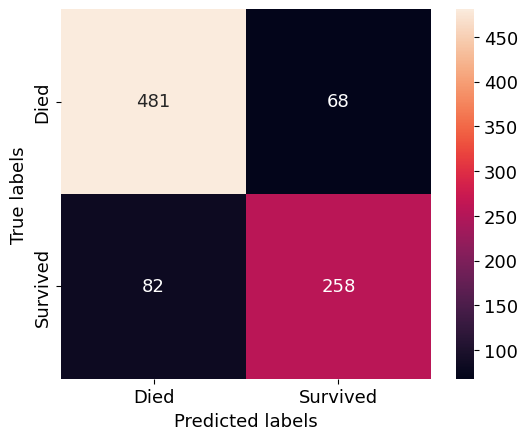

In [63]:
cm = confusion_matrix(y_train,y_train_pred)

ax = plt.subplot()

sns.heatmap(cm, square = True, annot = True, cbar =True, fmt='g',
           xticklabels=['Died','Survived'], yticklabels=['Died','Survived'], ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.savefig('Figures/ConfusionMatrix.png')
plt.show()

In [64]:
print("Accuracy :", accuracy_score(y_train,y_train_pred))
print("Precision :", precision_score(y_train,y_train_pred))
print("Recall :", recall_score(y_train,y_train_pred))
print("F1 Score :", f1_score(y_train,y_train_pred))

Accuracy : 0.8312710911136107
Precision : 0.7914110429447853
Recall : 0.7588235294117647
F1 Score : 0.7747747747747747


In [65]:
y_scores = model.predict_proba(X_train)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

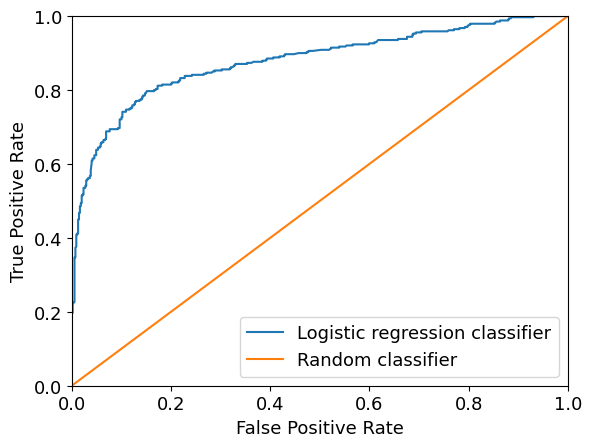

In [66]:
plt.plot(fpr, tpr, label = "Logistic regression classifier")
plt.plot([0, 1], [0, 1], label = "Random classifier")
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('Figures/Rocauccurve.png')

In [67]:
roc_auc_score(y_train, y_scores)

0.8777215257687775

### Kernel based model

In [68]:
clf = Pipeline([
    ('nys', Nystroem(kernel='rbf', n_components=800)),
    ('lr', LogisticRegressionCV(max_iter=500000, Cs = 10, class_weight='balanced'))
])
clf.fit(X_train, y_train)

Pipeline(steps=[('nys', Nystroem(n_components=800)),
                ('lr',
                 LogisticRegressionCV(class_weight='balanced',
                                      max_iter=500000))])

In [69]:
y_train_pred_kernel = clf.predict(X_train)

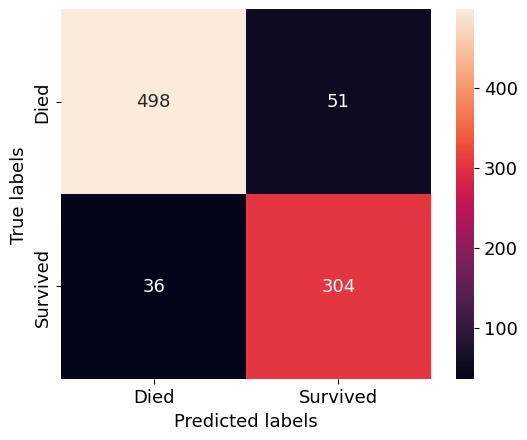

In [70]:
cm = confusion_matrix(y_train,y_train_pred_kernel)

ax = plt.subplot()

sns.heatmap(cm, square = True, annot = True, cbar =True, fmt='g',
           xticklabels=['Died','Survived'], yticklabels=['Died','Survived'], ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.savefig('Figures/ConfusionMatrix_kernel.png', bbox_inches = 'tight')

In [71]:
print("Accuracy :", accuracy_score(y_train,y_train_pred_kernel))
print("Precision :", precision_score(y_train,y_train_pred_kernel))
print("Recall :", recall_score(y_train,y_train_pred_kernel))
print("F1 Score :", f1_score(y_train,y_train_pred_kernel))

Accuracy : 0.9021372328458943
Precision : 0.856338028169014
Recall : 0.8941176470588236
F1 Score : 0.874820143884892


In [72]:
y_scores = clf.predict_proba(X_train)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

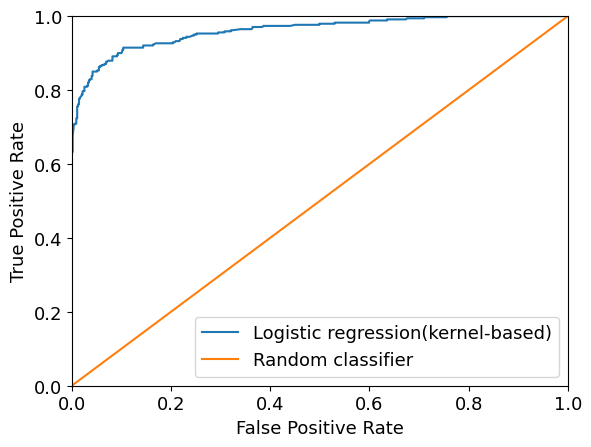

In [73]:
plt.plot(fpr, tpr, label = "Logistic regression(kernel-based)")
plt.plot([0, 1], [0, 1], label = "Random classifier")
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.savefig('Figures/Rocauccurve_kernel.png')